In [14]:
from langchain_community.tools.tavily_search import TavilySearchResults
tool=TavilySearchResults(max_results=5)
tools=[tool]
tool.invoke("What is the capital of France?")

[{'title': 'List of capitals of France - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/List_of_capitals_of_France',
  'content': 'Find sources:\xa0"List of capitals of France"\xa0–\xa0news\xa0· newspapers\xa0· books\xa0· scholar\xa0· JSTOR (July 2012) (Learn how and when to remove this message)\nThis is a chronological list of capitals of France. The capital of France has been Paris since its liberation in 1944.[1]\nChronology[edit]\nTournai (before 486), current-day Belgium\nSoissons (486–936)\nLaon (936–987)\nParis (987–1419), the residence of the Kings of France, although they were consecrated at Reims. [...] Bordeaux (September 1914), the government was relocated from Paris to Bordeaux very briefly during World War I, when it was feared that Paris would soon fall into German hands. These fears were alleviated after the German Army was pushed back at the First Battle of the Marne.\nTours (10–13 June 1940), the city served as the temporary capital of France during World War II 

In [15]:
from typing import Annotated

from langchain_groq import ChatGroq
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatGroq(model="llama-3.1-8b-instant")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [16]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [17]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

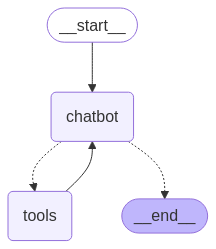

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
from langchain_core.messages import AIMessage, ToolMessage

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            for message in value.get("messages", []):
                if isinstance(message, AIMessage):
                    print("Assistant:", message.content)
                elif isinstance(message, ToolMessage):
                    print("🔧 Tool Result:", message.content)


In [20]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I'm happy to chat with you. Is there something I can help you with or would you like to discuss a particular topic?
Assistant: 
🔧 Tool Result: [{"title": "President of India - Wikipedia", "url": "https://en.wikipedia.org/wiki/President_of_India", "content": "The president of India (ISO: Bh\u0101rata k\u0113 R\u0101\u1e63\u1e6drapati) is the head of state of the Republic of India. The president is the nominal head of the executive,[a] the first citizen of the country, as well as the supreme commander of the Indian Armed Forces. Droupadi Murmu is the 15th and current president, having taken office from 25 July 2022. [...] Jump to content\nMain menu\nSearch\nDonate\nCreate account\nLog in\nPersonal tools\nToggle the table of contents\nPresident of India\n70 languages\nArticle\nTalk\nRead\nView source\nView history\nTools\nFrom Wikipedia, the free encyclopedia\nFor a list of presidents, see List of presidents of India.\nPresident of India\nBh\u0101rata k\u0113 R\u0101\u1e63\u1e6